<a href="https://colab.research.google.com/github/adityspecial/neural_network/blob/main/neural_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install snntorch tonic torch torchvision matplotlib numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 522.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
# Uninstall existing numpy
!pip uninstall -y numpy

# Install compatible version
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [11]:
!pip install tonic

In [1]:
import tonic
from tonic import DiskCachedDataset

# Download and preprocess the dataset
dataset = tonic.datasets.DVSGesture(save_to='./data', train=True)

# Apply transformations to convert events to frames
sensor_size = dataset.sensor_size
frame_transform = tonic.transforms.ToFrame(
    sensor_size=sensor_size,
    n_time_bins=10,  # Split each sample into 10 time bins
)

# Wrap the dataset with transformations and caching
cached_dataset = DiskCachedDataset(
    dataset,
    transform=frame_transform,
    cache_path='./cached_data',
)


  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture


Sample shape: (10, 2, 128, 128)


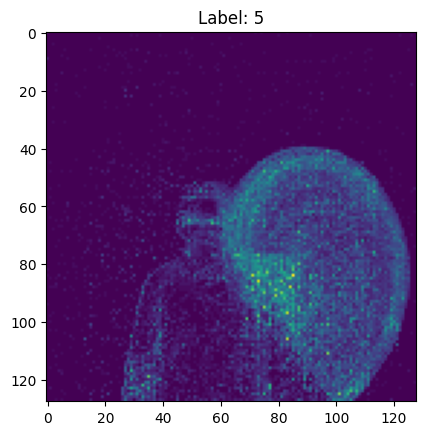

In [2]:
import matplotlib.pyplot as plt

sample, label = cached_dataset[0]
print(f"Sample shape: {sample.shape}")  # (Time bins, Channels, Height, Width)

# Plot the first time bin
plt.imshow(sample[0, 0])  # [time_bin, channel=0, height, width]
plt.title(f"Label: {label}")
plt.show()

In [3]:
import torch
import torch.nn as nn
import snntorch as snn

class SNN(nn.Module):
    def __init__(self, beta=0.5):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=2)
        self.lif1 = snn.Leaky(beta=beta)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.lif2 = snn.Leaky(beta=beta)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 11)  # 11 classes in DVS128 Gesture

    def forward(self, x):
        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Time-loop (unfold over time bins)
        outputs = []
        for t in range(x.shape[1]):  # x shape: (batch, time, C, H, W)
            x_t = x[:, t, :, :, :]

            x_t = self.conv1(x_t)
            spk1, mem1 = self.lif1(x_t, mem1)

            x_t = self.conv2(spk1)
            spk2, mem2 = self.lif2(x_t, mem2)

            x_t = self.pool(spk2)
            x_t = x_t.view(x_t.size(0), -1)
            x_t = self.fc(x_t)
            outputs.append(x_t)

        return torch.stack(outputs, dim=0).mean(dim=0)  # Average over time

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN().to(device)
print(model)

SNN(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(2, 2))
  (lif1): Leaky()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (lif2): Leaky()
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=11, bias=True)
)


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
sample, label = cached_dataset[0]
print(sample.shape)  # Expected: (time_bins, channels, height, width)

(10, 2, 128, 128)


In [7]:
from tqdm import tqdm

num_epochs = 15
batch_size = 32

# Create a DataLoader
train_loader = torch.utils.data.DataLoader(
    cached_dataset, batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, labels in tqdm(train_loader):
        data = data.to(device).float()
        labels = labels.to(device).long()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

torch.save(model.state_dict(), "gesture_model.pth")

100%|██████████| 34/34 [06:16<00:00, 11.08s/it]


Epoch 1, Loss: 2.3728129583246567


100%|██████████| 34/34 [04:24<00:00,  7.78s/it]


Epoch 2, Loss: 2.34145182020524


100%|██████████| 34/34 [04:10<00:00,  7.36s/it]


Epoch 3, Loss: 2.3197694105260513


100%|██████████| 34/34 [04:16<00:00,  7.55s/it]


Epoch 4, Loss: 2.2861216839622047


100%|██████████| 34/34 [04:11<00:00,  7.38s/it]


Epoch 5, Loss: 2.2562590767355526


100%|██████████| 34/34 [04:10<00:00,  7.37s/it]


Epoch 6, Loss: 2.2111305980121387


100%|██████████| 34/34 [04:21<00:00,  7.69s/it]


Epoch 7, Loss: 2.1663785261266373


100%|██████████| 34/34 [04:08<00:00,  7.32s/it]


Epoch 8, Loss: 2.1345123403212605


100%|██████████| 34/34 [04:20<00:00,  7.67s/it]


Epoch 9, Loss: 2.0973960091085995


100%|██████████| 34/34 [04:15<00:00,  7.53s/it]


Epoch 10, Loss: 2.0793678830651676


100%|██████████| 34/34 [04:13<00:00,  7.45s/it]


Epoch 11, Loss: 2.063295560724595


100%|██████████| 34/34 [04:10<00:00,  7.36s/it]


Epoch 12, Loss: 2.042049965437721


100%|██████████| 34/34 [04:10<00:00,  7.37s/it]


Epoch 13, Loss: 2.0322754838887382


100%|██████████| 34/34 [04:37<00:00,  8.15s/it]


Epoch 14, Loss: 2.0260953026659347


100%|██████████| 34/34 [04:18<00:00,  7.61s/it]

Epoch 15, Loss: 2.034871024243972


In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()

# Initialize SGD with momentum
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-20
)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, labels in tqdm(train_loader):
        data = data.to(device).float()
        labels = labels.to(device).long()

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

100%|██████████| 34/34 [04:31<00:00,  7.97s/it]


Epoch 1, Loss: 1.9718491575297188


 88%|████████▊ | 30/34 [04:03<00:32,  8.10s/it]


KeyboardInterrupt: 

In [11]:
# Define the transform (same as training)
sensor_size = tonic.datasets.DVSGesture.sensor_size
frame_transform = tonic.transforms.ToFrame(
    sensor_size=sensor_size,
    n_time_bins=10,  # Match the training setup
)

# Load and transform test dataset
test_dataset = tonic.datasets.DVSGesture(save_to='./data', train=False)
cached_test_dataset = DiskCachedDataset(
    test_dataset,
    transform=frame_transform,
    cache_path='./cached_test_data',  # Separate cache for test data
)

# Create test DataLoader
test_loader = torch.utils.data.DataLoader(cached_test_dataset, batch_size=32)

In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device).float()  # Ensure float32
        labels = labels.to(device).long()

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")

Accuracy: 27.651515151515152%


In [ ]:
pip install opencv-python

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms

# Load your trained model
model = SNN().to(device)
model.load_state_dict(torch.load("gesture_model.pth"))
model.eval()

# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 = default camera
prev_frame = None
time_window = 10  # Match training's time bins
buffer = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))  # Match DVS resolution
    gray = gray.astype(np.float32) / 255.0

    # Simulate event data: Compute difference from previous frame
    if prev_frame is not None:
        diff = gray - prev_frame
        diff = np.clip(diff, -0.5, 0.5) * 2.0  # Normalize to [-1, 1]

        # Split into ON/OFF channels (mimic DVS polarity)
        on_events = np.where(diff > 0.1, diff, 0)
        off_events = np.where(diff < -0.1, -diff, 0)
        pseudo_event = np.stack([on_events, off_events], axis=0)  # Shape: (2, 128, 128)

        buffer.append(pseudo_event)
        if len(buffer) > time_window:
            buffer.pop(0)

    prev_frame = gray

    # Run inference when buffer is full
    if len(buffer) == time_window:
        # Convert buffer to tensor (shape: [1, time=10, channels=2, H, W])
        input_tensor = torch.tensor(np.stack(buffer), dtype=torch.float32).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)

        # Display prediction
        label = predicted.item()
        cv2.putText(frame, f"Gesture: {label}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    cv2.imshow('Live Gesture Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Map label IDs to actions (customize these!)
gesture_actions = {
    0: "volume_up",    # Swipe Right → Increase volume
    1: "volume_down",  # Swipe Left → Decrease volume
    2: "play_pause",   # Upward Motion → Toggle media play/pause
    3: "alt+tab",      # Circle → Switch apps
    4: "scroll_down",  # Counter-Clockwise → Scroll down
    # ... Add more gestures
}

In [ ]:
pip install pyautogui

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.2/171.2 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyautogui: filename=pyautogui-0.9.54-py3-none-any.whl size=37632 sha256=0c1d831fdfdd4c9d247b0d165cd9b116febbafdbe759bc9b69a1a

In [ ]:
import pyautogui

def trigger_action(action):
    if action == "volume_up":
        pyautogui.press('volumeup')
    elif action == "volume_down":
        pyautogui.press('volumedown')
    elif action == "play_pause":
        pyautogui.press('playpause')
    elif action == "alt+tab":
        pyautogui.hotkey('alt', 'tab')
    elif action == "scroll_down":
        pyautogui.scroll(-100)  # Scroll down
    # Add more actions...

KeyError: 'DISPLAY'